In [6]:
import numpy as np
import xarray as xr
import dask.array as da
from dask.distributed import Client, LocalCluster
import gc
import sys
from matplotlib import pyplot as plt

In [7]:
EARTH_RADIUS_KM = 6371.0
MAX_DIST_KM = 500
TIME_TOL_HOURS = 8
ALT_MIN, ALT_MAX = 0.5, 64.5
ALT_GRID = np.arange(ALT_MIN, ALT_MAX + 1, dtype=np.float32)
TIME_TOL = np.timedelta64(TIME_TOL_HOURS, 'h').astype('timedelta64[ns]')

CHUNK_SIZE_L = 50000
CHUNK_SIZE_S = 25000

In [8]:
def process_dataarray(da_o3):
    da_transposed = da_o3.transpose('time', 'altitude')
    
    n_time = da_transposed.sizes['time']
    n_alt = da_transposed.sizes['altitude']
    
    time_chunks = CHUNK_SIZE_L if n_time > 500000 else CHUNK_SIZE_S
    alt_chunks = min(32, n_alt)
    
    if isinstance(da_transposed.data, da.Array):
        da_transposed = da_transposed.chunk({'time': time_chunks, 'altitude': alt_chunks})
    else:
        da_transposed.data = da.from_array(da_transposed.data, 
                                          chunks=(time_chunks, alt_chunks))
    
    return da_transposed

def compute_diffs(o3L, o3S):
    """Vectorized relative and absolute difference computation"""
    sum_vals = o3L + o3S
    diff_vals = o3L - o3S
    return 200 * (diff_vals / sum_vals), diff_vals

def haversine_vectorized(lat1, lon1, lat2, lon2):
    """Vectorized Haversine distance calculation between points (in radians)"""
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return EARTH_RADIUS_KM * c

In [9]:
sys.path.extend([
    r"C:\Users\salla\Onedrive(uoft acc)\OneDrive - University of Toronto\Desktop\School Information\NSERC\NSERC\OSIRIS",
    r"C:\Users\salla\Onedrive(uoft acc)\OneDrive - University of Toronto\Desktop\School Information\NSERC\NSERC\ACEFTS"
])

import OSIRIS_helper as OSIRIS
import ACEFTS_helper as ACE

In [10]:
daL = OSIRIS.get_vmr()
daS = ACE.get_vmr()

In [11]:
daL = daL.sel(altitude=slice(ALT_MIN, ALT_MAX)).interp({"altitude": ALT_GRID})
daS = daS.sel(altitude=slice(ALT_MIN, ALT_MAX)).interp({"altitude": ALT_GRID})

daL = process_dataarray(daL)
daS = process_dataarray(daS)

assert np.array_equal(daL.altitude.values, ALT_GRID), "OSIRIS alt mismatch!"
assert np.array_equal(daS.altitude.values, ALT_GRID), "ACE-FTS alt mismatch!"

In [12]:
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit='3GB',
    processes=False,
    dashboard_address=None
)
client = Client(cluster)


In [13]:
o3L_arr = daL.values.astype(np.float32)
o3S_arr = daS.values.astype(np.float32)
tL = daL.time.values.astype('datetime64[ns]')
tS = daS.time.values.astype('datetime64[ns]')
latL = daL.latitude.values
lonL = daL.longitude.values
latS = daS.latitude.values
lonS = daS.longitude.values

tS_min = tS.min() - TIME_TOL
tS_max = tS.max() + TIME_TOL
time_mask = (tL >= tS_min) & (tL <= tS_max)
tL_filtered = tL[time_mask]
o3L_arr_filtered = o3L_arr[time_mask]
latL_filtered = latL[time_mask]
lonL_filtered = lonL[time_mask]

client.close()
cluster.close()
del o3L_arr, latL, lonL
gc.collect()

C:\Users\salla\AppData\Roaming\Python\Python312\site-packages\distributed\client.py:3363: UserWarning: Sending large graph of size 65.50 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


47037

In [14]:
tL_ns = tL_filtered.astype(np.int64)
tS_ns = tS.astype(np.int64)
TIME_TOL_ns = TIME_TOL.astype(np.int64)

n_alt = len(ALT_GRID)
MAX_DIST_RAD = MAX_DIST_KM / EARTH_RADIUS_KM

processed_pairs = 0
o3S_coincidences = []
o3L_coincidences = []

time_bins = np.arange(tL_ns.min(), tL_ns.max() + 1, TIME_TOL_ns)
bin_indices = np.digitize(tL_ns, time_bins)

max_bin = len(time_bins) + 1
time_binned_arrays = [np.array([], dtype=np.int64) for _ in range(max_bin + 1)]

for bin_id in range(0, max_bin + 1):
    time_binned_arrays[bin_id] = np.where(bin_indices == bin_id)[0]

bin_offsets = np.arange(-1, 2)

for s_idx, (s_time, s_lat, s_lon) in enumerate(zip(tS_ns, latS, lonS)):
    if s_idx % 10000 == 0:
        print(f"Processing ACE-FTS point {s_idx}/{len(tS)}...")
    
    center_bin = np.digitize(s_time, time_bins)
    bin_ids = center_bin + bin_offsets
    bin_ids = bin_ids[(bin_ids >= 1) & (bin_ids < max_bin)]

    candidate_indices = np.concatenate([time_binned_arrays[bin_id] for bin_id in bin_ids])
    if candidate_indices.size == 0:
        continue

    time_diffs = np.abs(tL_ns[candidate_indices] - s_time)
    time_mask = time_diffs <= TIME_TOL_ns

    if not np.any(time_mask):
        continue

    time_valid_indices = candidate_indices[time_mask]
    candidate_lats = latL_filtered[time_valid_indices]
    candidate_lons = lonL_filtered[time_valid_indices]
    
    dists = haversine_vectorized(s_lat, s_lon, candidate_lats, candidate_lons)
    min_idx = np.argmin(dists)
    min_dist = dists[min_idx]

    if min_dist <= MAX_DIST_KM:
        best_L_idx = time_valid_indices[min_idx]
        o3L_coincidences.append(o3L_arr_filtered[best_L_idx])
        o3S_coincidences.append(o3S_arr[s_idx])
        processed_pairs += 1
        if processed_pairs % 1000 == 0:
            print(f"Found {processed_pairs} pairs at ACE point {s_idx}...")

o3S_coincidences = np.vstack(o3S_coincidences)
o3L_coincidences = np.vstack(o3L_coincidences)
print(f"Total coincidences found: {processed_pairs}")

Processing ACE-FTS point 0/132071...
Found 1000 pairs at ACE point 8000...
Processing ACE-FTS point 10000/132071...
Found 2000 pairs at ACE point 14787...
Found 3000 pairs at ACE point 18636...
Processing ACE-FTS point 20000/132071...
Found 4000 pairs at ACE point 21806...
Found 5000 pairs at ACE point 25733...
Found 6000 pairs at ACE point 28948...
Processing ACE-FTS point 30000/132071...
Found 7000 pairs at ACE point 33613...
Found 8000 pairs at ACE point 38886...
Processing ACE-FTS point 40000/132071...
Found 9000 pairs at ACE point 43522...
Found 10000 pairs at ACE point 47727...
Processing ACE-FTS point 50000/132071...
Found 11000 pairs at ACE point 57521...
Processing ACE-FTS point 60000/132071...
Found 12000 pairs at ACE point 68777...
Processing ACE-FTS point 70000/132071...
Processing ACE-FTS point 80000/132071...
Found 13000 pairs at ACE point 81030...
Processing ACE-FTS point 90000/132071...
Found 14000 pairs at ACE point 99309...
Processing ACE-FTS point 100000/132071...
Pr

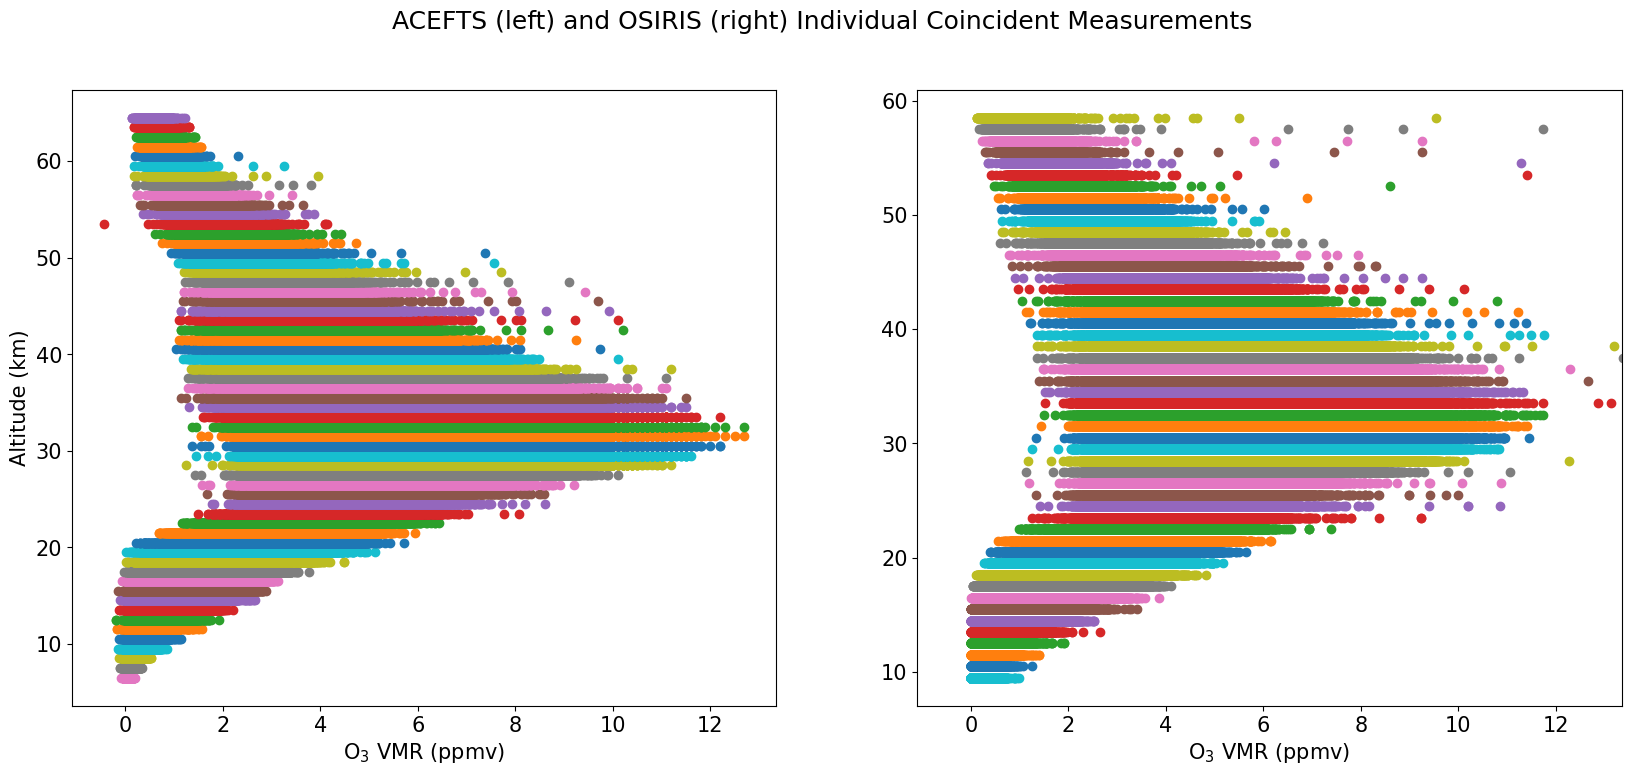

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (20,8))
for i, alt in enumerate(ALT_GRID):
    axes[0].scatter(o3S_coincidences[:,i] * 10**6, [alt] * o3S_coincidences.shape[0])

for i, alt in enumerate(ALT_GRID):
    axes[1].scatter(o3L_coincidences[:,i] * 10**6, [alt] * o3L_coincidences.shape[0])

axes[1].set_xlim(*axes[0].get_xlim())

axes[0].set_xlabel("O$_3$ VMR (ppmv)")
axes[1].set_xlabel("O$_3$ VMR (ppmv)")
axes[0].set_ylabel("Altitude (km)")

plt.suptitle("ACEFTS (left) and OSIRIS (right) Individual Coincident Measurements")

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

In [16]:
rel, abs = compute_diffs(o3L_coincidences, o3S_coincidences)

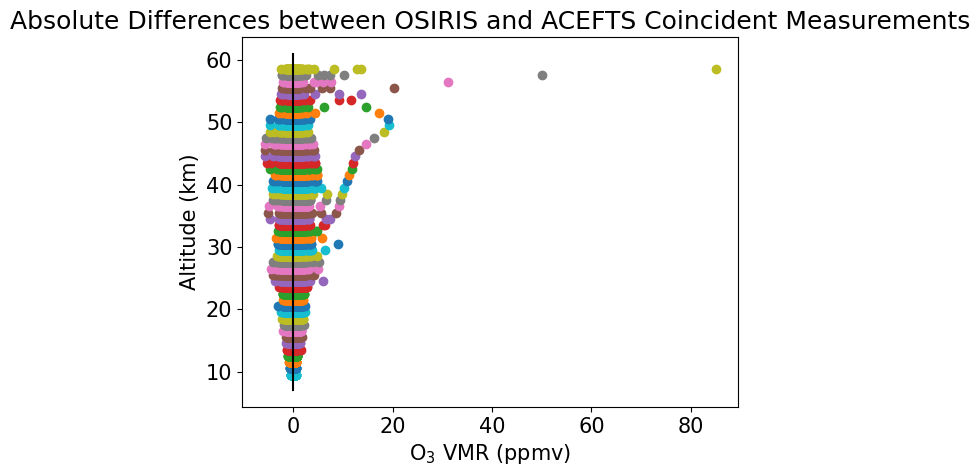

In [17]:
for i, alt in enumerate(ALT_GRID):
    plt.scatter(abs[:,i] * 10**6, [alt] * abs.shape[0])

plt.plot([0, 0], list(plt.ylim()), color = "black")
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Absolute Differences between OSIRIS and ACEFTS Coincident Measurements")

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [18]:
rel_diffs = np.nanmean(rel, axis = 0)
rel_std = np.nanstd(rel, axis = 0)
rel_err = rel_std / (rel.shape[0] ** 0.5)

abs_diffs = np.nanmean(abs, axis = 0)
abs_std = np.nanstd(abs, axis = 0)
abs_err = np.nanstd(abs, axis = 0) / (abs.shape[0] ** 0.5)

C:\Users\salla\AppData\Local\Temp\ipykernel_12640\1016612721.py:1: RuntimeWarning: Mean of empty slice
  rel_diffs = np.nanmean(rel, axis = 0)
C:\Users\salla\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\salla\AppData\Local\Temp\ipykernel_12640\1016612721.py:5: RuntimeWarning: Mean of empty slice
  abs_diffs = np.nanmean(abs, axis = 0)


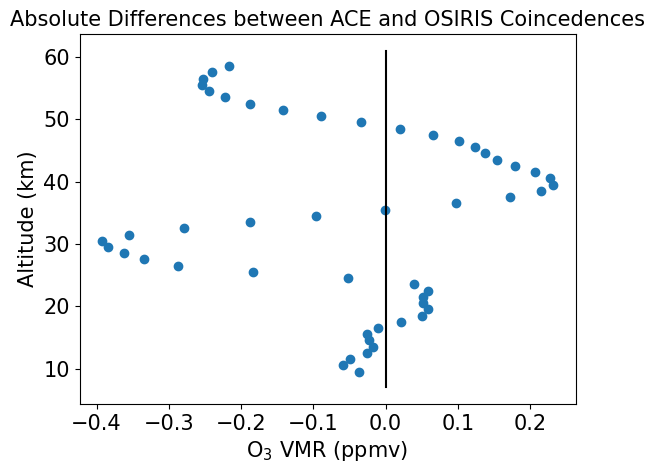

In [19]:
plt.scatter(abs_diffs * 10**6, ALT_GRID)
plt.plot([0, 0], list(plt.ylim()), color = "black")
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Absolute Differences between ACE and OSIRIS Coincedences", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

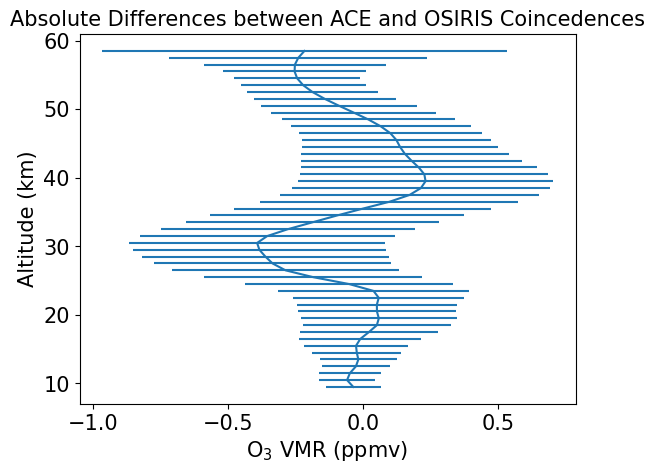

In [20]:
plt.errorbar(abs_diffs * 10**6, ALT_GRID, xerr = abs_std * 10**6)
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Absolute Differences between ACE and OSIRIS Coincedences", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title + "(std)", bbox_inches="tight")

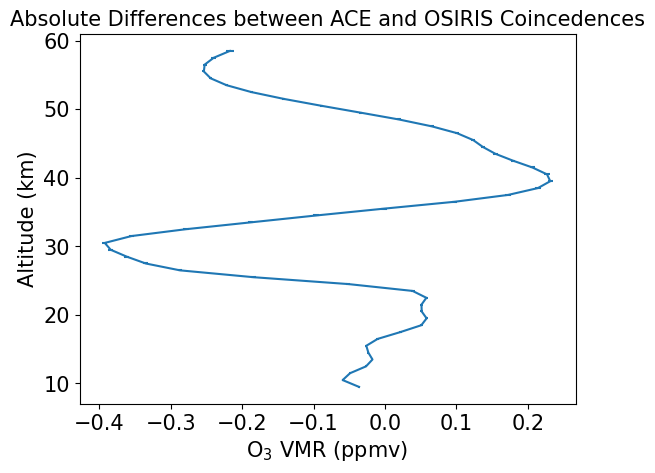

In [21]:
plt.errorbar(abs_diffs * 10**6, ALT_GRID, xerr = abs_err * 10**6)
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Absolute Differences between ACE and OSIRIS Coincedences", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title + "(err)", bbox_inches="tight")

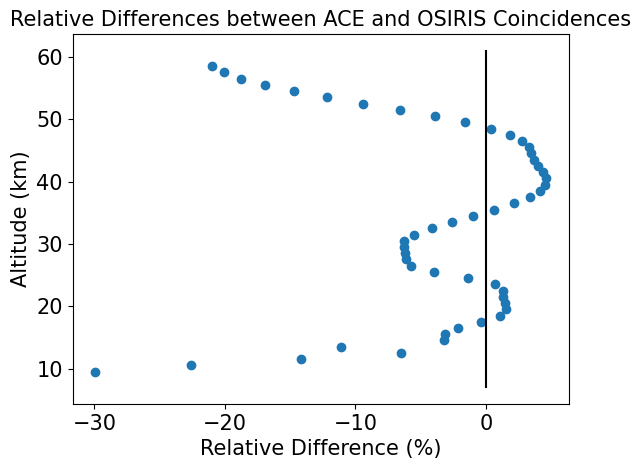

In [22]:
plt.scatter(rel_diffs, ALT_GRID)
plt.plot([0, 0], list(plt.ylim()), color = "black")
plt.xlabel("Relative" + " Difference (%)")
plt.ylabel("Altitude (km)")
plt.title("Relative Differences between ACE and OSIRIS Coincidences", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

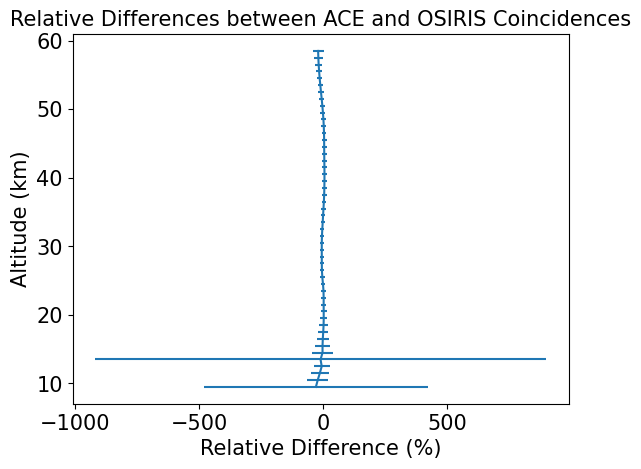

In [23]:
plt.errorbar(rel_diffs, ALT_GRID, xerr = rel_std)
plt.xlabel("Relative" + " Difference (%)")
plt.ylabel("Altitude (km)")
plt.title("Relative Differences between ACE and OSIRIS Coincidences", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title + "(std)", bbox_inches="tight")

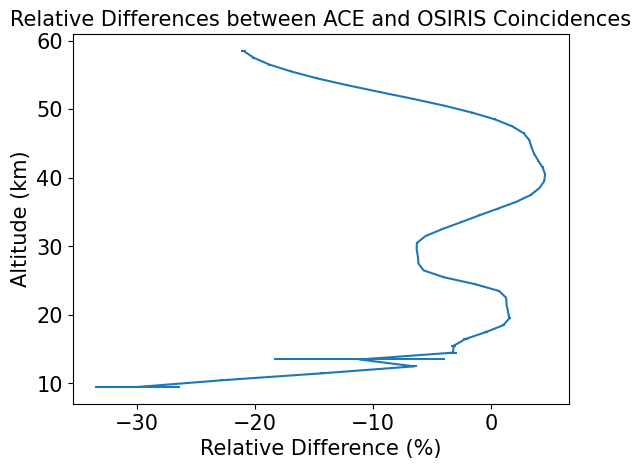

In [24]:
plt.errorbar(rel_diffs, ALT_GRID, xerr = rel_err)
plt.xlabel("Relative" + " Difference (%)")
plt.ylabel("Altitude (km)")
plt.title("Relative Differences between ACE and OSIRIS Coincidences", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title + "(err)", bbox_inches="tight")

C:\Users\salla\AppData\Local\Temp\ipykernel_12640\2188114250.py:1: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(o3L_coincidences, axis = 0) * 10**6, ALT_GRID, label = "OSIRIS")
C:\Users\salla\AppData\Local\Temp\ipykernel_12640\2188114250.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(o3S_coincidences, axis = 0) * 10**6, ALT_GRID, label = "ACEFTS")


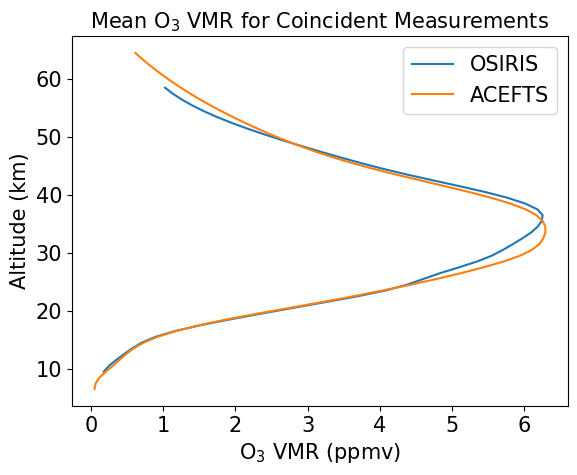

In [25]:
plt.plot(np.nanmean(o3L_coincidences, axis = 0) * 10**6, ALT_GRID, label = "OSIRIS")
plt.plot(np.nanmean(o3S_coincidences, axis = 0) * 10**6, ALT_GRID, label = "ACEFTS")
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Mean O$_3$ VMR for Coincident Measurements", fontdict = {'fontsize': 15})
plt.legend()

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title + "(OSIRIS and ACEFTS)", bbox_inches="tight")

In [26]:
o3L_std = np.nanstd(o3L_coincidences, axis = 0)[None, :]
o3S_std = np.nanstd(o3S_coincidences, axis = 0)[None, :]
o3L_mean = np.nanmean(o3L_coincidences, axis = 0)[None, :]
o3S_mean = np.nanmean(o3S_coincidences, axis = 0)[None, :]

C:\Users\salla\AppData\Local\Temp\ipykernel_12640\2217330616.py:3: RuntimeWarning: Mean of empty slice
  o3L_mean = np.nanmean(o3L_coincidences, axis = 0)[None, :]
C:\Users\salla\AppData\Local\Temp\ipykernel_12640\2217330616.py:4: RuntimeWarning: Mean of empty slice
  o3S_mean = np.nanmean(o3S_coincidences, axis = 0)[None, :]


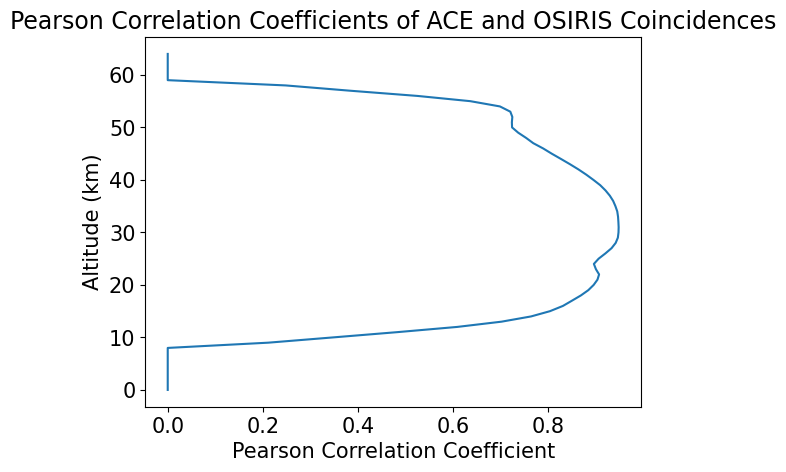

In [27]:
summing = np.nansum(((o3L_coincidences - o3L_mean) / o3L_std) * ((o3S_coincidences - o3S_mean) / o3S_std), axis = 0) 

plt.plot(summing / (o3L_coincidences.shape[0] - 1), np.arange(len(summing)))
plt.ylabel("Altitude (km)")
plt.xlabel("Pearson Correlation Coefficient")
plt.title("Pearson Correlation Coefficients of ACE and OSIRIS Coincidences", fontdict = {"fontsize": 17})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [ ]:
# fig = pcm_monthly.fig
# title = fig._suptitle.get_text()
# fig.savefig(title, bbox_inches="tight")

# fig = plt.gcf()
# axes = plt.gca()

# title = axes.get_title()
# fig.savefig(title, bbox_inches="tight")